# IMPORTS

In [3]:
# Clone the Git repository and navigate to the project directory
!git clone https://github.com/DanteMillerDS/NASA-Material-Classifier.git
%cd NASA-Material-Classifier

# Install required packages
!pip install xgboost
!pip install pytorch-tabnet
!pip install torch

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import torch
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mean_absolute_error
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold
from keras.layers import Bidirectional, LSTM, Dense
import numpy as np
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetRegressor
import uuid

# Set random seeds for reproducibility
np.random.seed(1000)
tf.random.set_seed(1000)

Cloning into 'NASA-Material-Classifier'...
remote: Enumerating objects: 165, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 165 (delta 3), reused 13 (delta 2), pack-reused 150
Receiving objects: 100% (165/165), 229.30 MiB | 13.46 MiB/s, done.
Resolving deltas: 100% (43/43), done.
Updating files: 100% (65/65), done.
/content/NASA-Material-Classifier


# PREPROCESSING

In [4]:
# Read training files
file_paths = dict()
file_paths[0] = [
    "data/moon_rock/simulated/S11_parameter_data_for_zero_orientation.txt",
    "data/moon_rock/simulated/S12_parameter_data_for_zero_orientation.txt",
    "data/moon_rock/simulated/S21_parameter_data_for_zero_orientation.txt",
    "data/moon_rock/simulated/S22_parameter_data_for_zero_orientation.txt"]
file_paths[1] = [
    "data/moon_rock/simulated/S11_parameter_data_for_CW90_orientation.txt",
    "data/moon_rock/simulated/S12_parameter_data_for_CW90_orientation.txt",
    "data/moon_rock/simulated/S21_parameter_data_for_CW90_orientation.txt",
    "data/moon_rock/simulated/S22_parameter_data_for_CW90_orientation.txt"]
file_paths[2] = [
    "data/moon_rock/simulated/S11_parameter_data_for_CCW90_orientation.txt",
    "data/moon_rock/simulated/S12_parameter_data_for_CCW90_orientation.txt",
    "data/moon_rock/simulated/S21_parameter_data_for_CCW90_orientation.txt",
    "data/moon_rock/simulated/S22_parameter_data_for_CCW90_orientation.txt"]
file_paths[3] = [
    "data/moon_rock/simulated/S11_parameter_data_for_tilt_orientation.txt",
    "data/moon_rock/simulated/S12_parameter_data_for_tilt_orientation.txt",
    "data/moon_rock/simulated/S21_parameter_data_for_tilt_orientation.txt",
    "data/moon_rock/simulated/S22_parameter_data_for_tilt_orientation.txt"]
def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    data = []
    for dataset in datasets:
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = file_path.split("_parameter_data_for_")[0]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        combined_data = pd.concat(combined_data, ignore_index=True)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for i in range(0, len(all_combined_data), group_size):
    combined_dataframe = pd.concat(all_combined_data[i:i+group_size], axis=1)
    combined_dataframe.reset_index(drop=True, inplace=True)
    array.append(combined_dataframe)
training_dataframe = pd.concat(array, axis=0)
training_dataframe.reset_index(drop=True, inplace=True)
training_dataframe = training_dataframe.loc[:, ~training_dataframe.columns.duplicated()]

In [5]:
# Read testing files
file_paths = dict()
file_paths[0] = ["data/moon_rock/actual/mea_rot_0.txt"]
file_paths[1] = ["data/moon_rock/actual/mea_rot_cw90.txt"]
file_paths[2] = ["data/moon_rock/actual/mea_rot_ccw90.txt"]
file_paths[3] = ["data/moon_rock/actual/mea_rot_0_tilt.txt"]
def process_file(file_path,orientation):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    dictionary = {
    0: "S11",
    1: "S21",
    2: "S12",
    3: "S22"
    }
    data = []
    for index, dataset in enumerate(datasets):
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = dictionary[index]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}_Real", f"{s_parameter_name}_Imaginary"])
        df["Orientation"] = orientation
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            if "er1" in key or "er11" in key:
                df[key] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file,index)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for group in range(len(all_combined_data)):
    for i in range(0, len(all_combined_data[group]), group_size):
        combined_dataframe = pd.concat(all_combined_data[group][i:i+group_size], axis=1)
        combined_dataframe.reset_index(drop=True, inplace=True)
        array.append(combined_dataframe)
testing_dataframe = pd.concat(array, axis=0)
testing_dataframe.reset_index(drop=True, inplace=True)
testing_dataframe = testing_dataframe.loc[:, ~testing_dataframe.columns.duplicated()]

In [6]:
# Print columns
print(training_dataframe.columns)
print(testing_dataframe.columns)

Index(['Frequency', 'data/moon_rock/simulated/S11_Real',
       'data/moon_rock/simulated/S11_Imaginary', 'Orientation', 'ID', 'er1',
       ' er11', 'data/moon_rock/simulated/S12_Real',
       'data/moon_rock/simulated/S12_Imaginary',
       'data/moon_rock/simulated/S21_Real',
       'data/moon_rock/simulated/S21_Imaginary',
       'data/moon_rock/simulated/S22_Real',
       'data/moon_rock/simulated/S22_Imaginary'],
      dtype='object')
Index(['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID', ' er1',
       ' er11', 'S21_Real', 'S21_Imaginary', 'S12_Real', 'S12_Imaginary',
       'S22_Real', 'S22_Imaginary'],
      dtype='object')


In [7]:
# Define variable names
training_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']
training_dataframe = training_dataframe[['ID','Frequency', 'Orientation', 'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]
testing_dataframe.columns = ['Frequency', 'S11_Real', 'S11_Imaginary', 'Orientation', 'ID','Permittivity_Real', 'Permittivity_Imaginary', 'S21_Real',
       'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real',
       'S22_Imaginary']
testing_dataframe = testing_dataframe[['ID','Frequency', 'Orientation',  'Permittivity_Real', 'Permittivity_Imaginary','S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary']]

In [8]:
# Print variable names
training_dataframe.columns
testing_dataframe.columns

Index(['ID', 'Frequency', 'Orientation', 'Permittivity_Real',
       'Permittivity_Imaginary', 'S11_Real', 'S11_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S21_Real', 'S21_Imaginary', 'S22_Real',
       'S22_Imaginary'],
      dtype='object')

In [9]:
# Drop na and applying numeric
training_dataframe.dropna(inplace=True)
columns = training_dataframe.columns[1:]
training_dataframe[columns] = training_dataframe[columns].apply(pd.to_numeric)
testing_dataframe.dropna(inplace=True)
testing_dataframe[columns] = testing_dataframe[columns].apply(pd.to_numeric)

In [10]:
# Remove id
training_dataframe = training_dataframe.iloc[:,1:]
testing_dataframe = testing_dataframe.iloc[:,1:]

In [11]:
# Set to 0.1
testing_dataframe['Permittivity_Imaginary'][testing_dataframe['Permittivity_Imaginary'] == 0.4] = 0.1

<ipython-input-11-2d803d5f2b6d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_dataframe['Permittivity_Imaginary'][testing_dataframe['Permittivity_Imaginary'] == 0.4] = 0.1


In [12]:
# Describe training dataframe
training_dataframe.describe()

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
count,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000,400400.000000
mean,1.350000,1.500000,5.118332,0.048120,-0.001584,-0.002185,-0.047022,-0.054192,-0.047022,-0.054192,0.000979,-0.001394
std,0.202275,1.118035,2.276409,0.028907,0.015331,0.016359,0.717936,0.684740,0.717936,0.684740,0.016112,0.015731
min,1.000000,0.000000,1.095217,0.000463,-0.035654,-0.041414,-0.995684,-0.994878,-0.995684,-0.994878,-0.039840,-0.041402
25%,1.175000,0.750000,3.055240,0.023333,-0.012621,-0.013896,-0.764701,-0.733799,-0.764701,-0.733799,-0.010682,-0.012373
50%,1.350000,1.500000,5.312052,0.045073,-0.002871,-0.001957,-0.111570,-0.084830,-0.111570,-0.084830,0.001433,-0.000090
75%,1.525000,2.250000,7.042521,0.077511,0.008562,0.009605,0.685784,0.613695,0.685784,0.613695,0.012647,0.010078
max,1.700000,3.000000,8.764742,0.099613,0.041451,0.040683,0.995090,0.995193,0.995090,0.995193,0.040707,0.035653


In [13]:
# Describe testing dataframe
testing_dataframe.describe()

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
count,4004.0000,4004.000000,4004.0,4.004000e+03,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000,4004.000000
mean,1.3500,1.500000,5.0,1.000000e-01,0.000577,0.000549,0.999238,-0.015901,0.999127,-0.016045,0.000196,0.000537
std,0.2023,1.118174,0.0,1.387952e-17,0.011171,0.011518,0.000563,0.002759,0.000539,0.002727,0.011191,0.011311
min,1.0000,0.000000,5.0,1.000000e-01,-0.020254,-0.019533,0.997404,-0.022488,0.997087,-0.022932,-0.016647,-0.019633
25%,1.1750,0.750000,5.0,1.000000e-01,-0.009929,-0.010517,0.998914,-0.017570,0.998798,-0.017717,-0.010537,-0.010187
50%,1.3500,1.500000,5.0,1.000000e-01,0.000705,0.001933,0.999316,-0.016833,0.999181,-0.016949,-0.000033,0.001886
75%,1.5250,2.250000,5.0,1.000000e-01,0.010853,0.011191,0.999648,-0.015271,0.999511,-0.015336,0.010635,0.010881
max,1.7000,3.000000,5.0,1.000000e-01,0.019258,0.017582,1.000619,-0.010323,1.000495,-0.010558,0.021095,0.017354


In [14]:
# Print training dataframe head
training_dataframe.head(5)

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,1.0000,0,2.260905,0.045054,0.010708,-0.001546,0.218818,0.964274,0.218818,0.964274,0.010327,-0.003227
1,1.0007,0,2.260905,0.045054,0.010755,-0.001773,0.237425,0.960461,0.237425,0.960461,0.010343,-0.003442
2,1.0014,0,2.260905,0.045054,0.010795,-0.002004,0.255947,0.956298,0.255947,0.956298,0.010353,-0.003656
3,1.0021,0,2.260905,0.045054,0.010828,-0.002238,0.274378,0.951784,0.274378,0.951784,0.010358,-0.003870
4,1.0028,0,2.260905,0.045054,0.010853,-0.002474,0.292710,0.946918,0.292710,0.946918,0.010356,-0.004082


In [15]:
# Print testing dataframe head
training_dataframe.head(5)

,Frequency,Orientation,Permittivity_Real,Permittivity_Imaginary,S11_Real,S11_Imaginary,S12_Real,S12_Imaginary,S21_Real,S21_Imaginary,S22_Real,S22_Imaginary
0,1.0000,0,2.260905,0.045054,0.010708,-0.001546,0.218818,0.964274,0.218818,0.964274,0.010327,-0.003227
1,1.0007,0,2.260905,0.045054,0.010755,-0.001773,0.237425,0.960461,0.237425,0.960461,0.010343,-0.003442
2,1.0014,0,2.260905,0.045054,0.010795,-0.002004,0.255947,0.956298,0.255947,0.956298,0.010353,-0.003656
3,1.0021,0,2.260905,0.045054,0.010828,-0.002238,0.274378,0.951784,0.274378,0.951784,0.010358,-0.003870
4,1.0028,0,2.260905,0.045054,0.010853,-0.002474,0.292710,0.946918,0.292710,0.946918,0.010356,-0.004082


# DATA VISUALIZATION

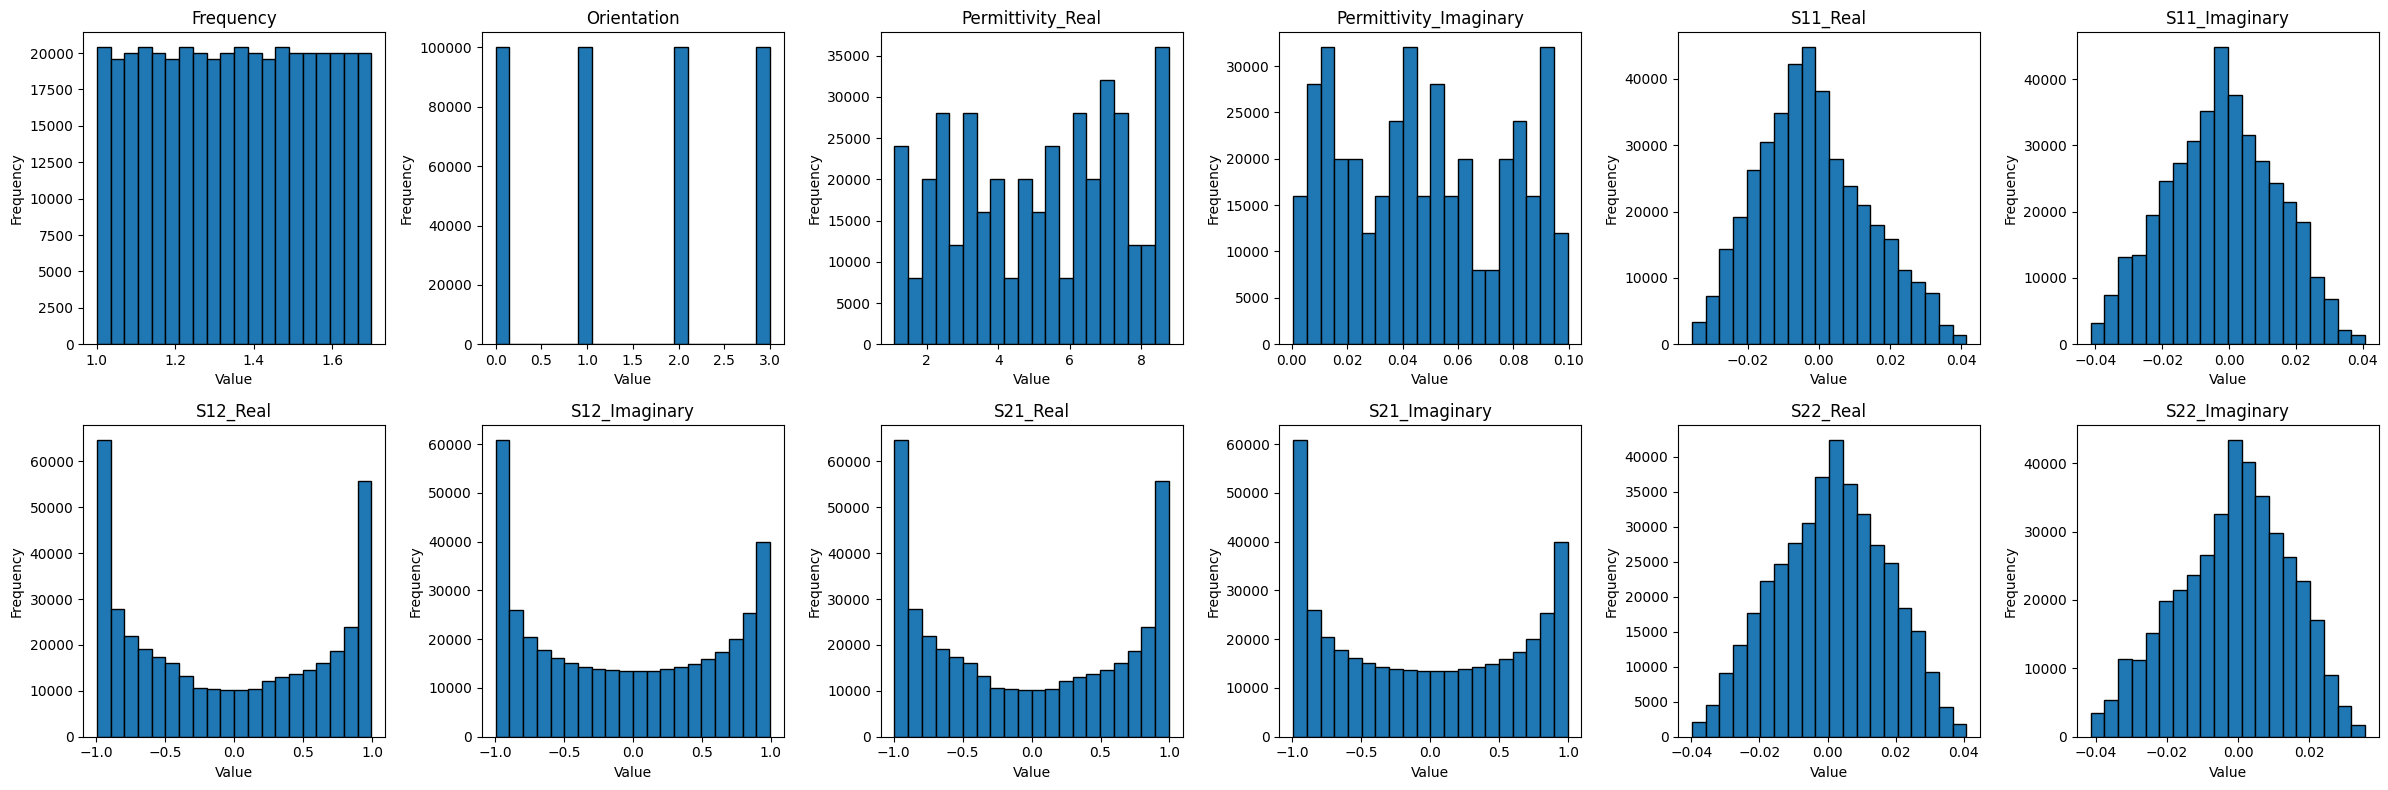

In [16]:
# Plot training dataframe columns
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

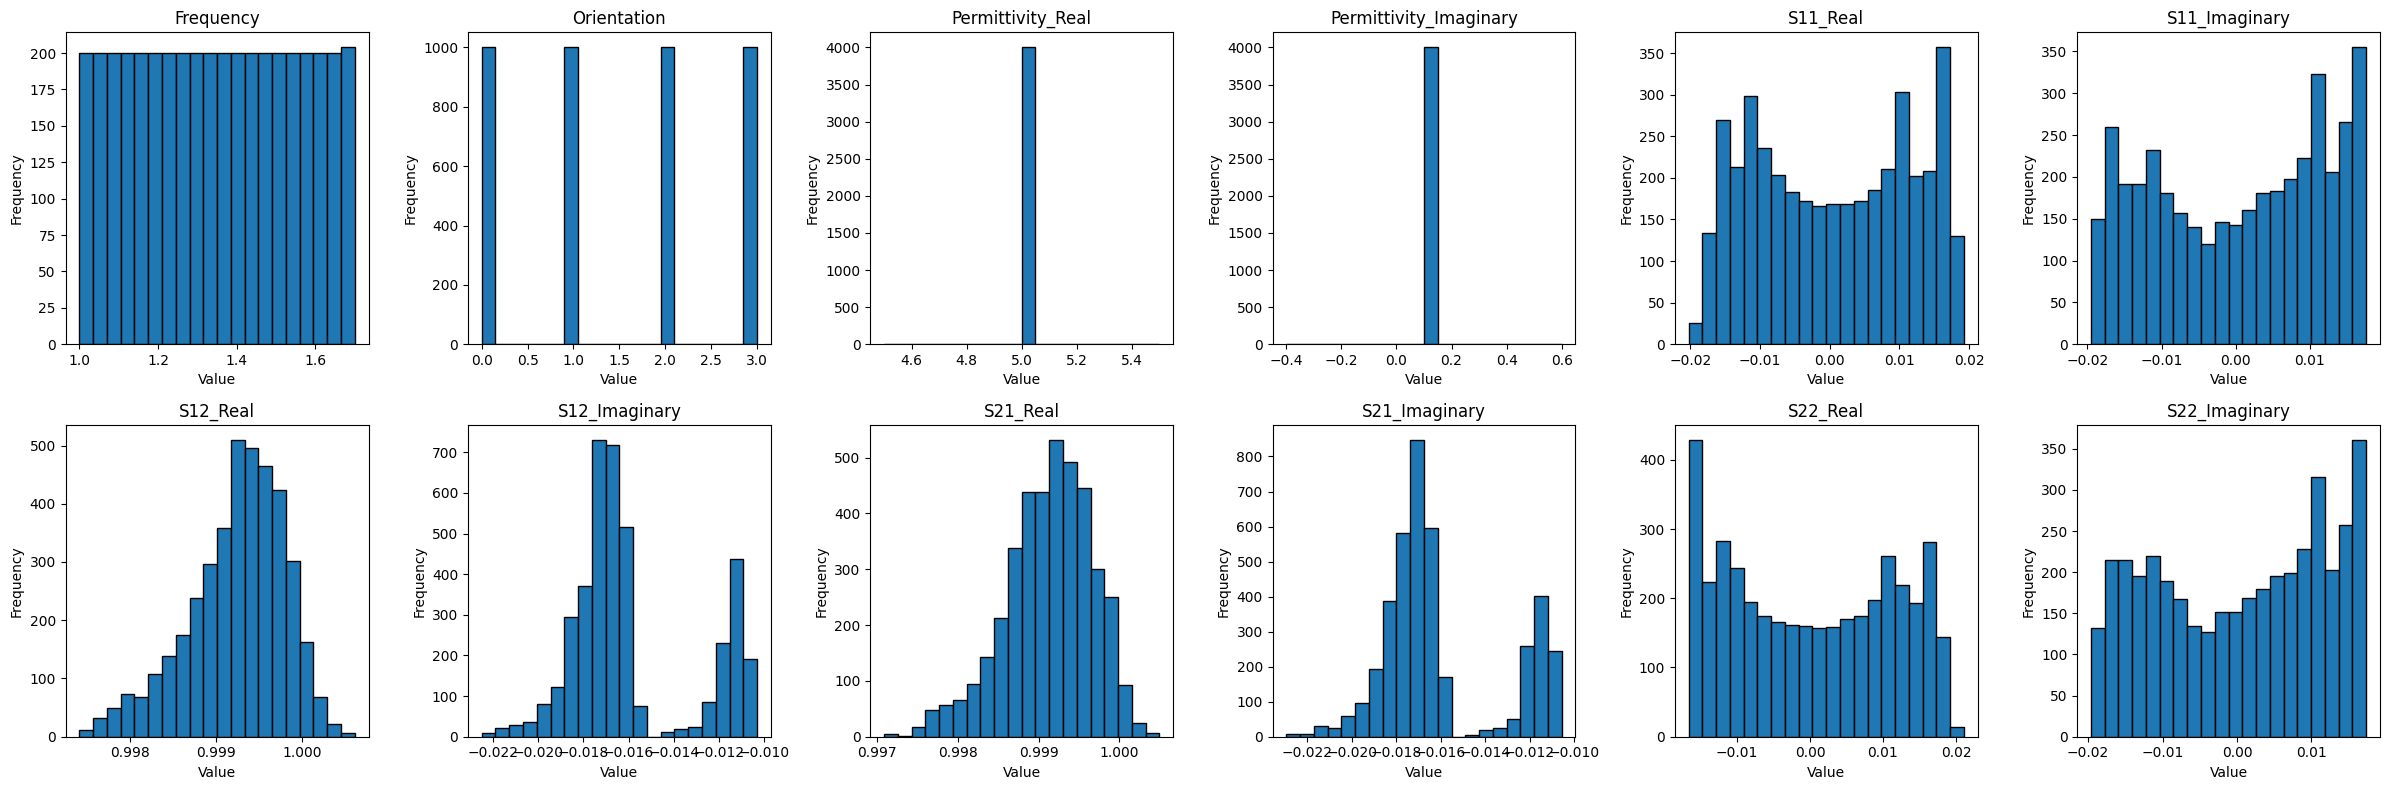

In [17]:
# Print testing dataframe columns
plt.figure(figsize=(24, 8))
for i, column in enumerate(testing_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(testing_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [18]:
# Grabbing column means
columns = training_dataframe.columns[3:]
training_mean_predicted_values = training_dataframe.groupby('Frequency')[columns].mean()
testing_mean_predicted_values = testing_dataframe.groupby('Frequency')[columns].mean()

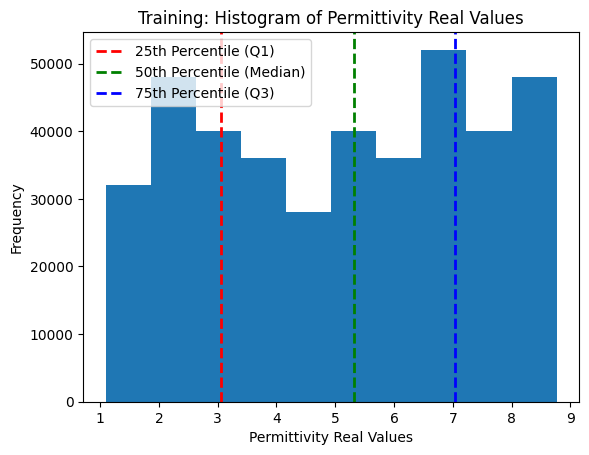

In [19]:
# Showing mean for the permittivity real training dataframe
q25 = np.percentile(training_dataframe["Permittivity_Real"], 25)
q50 = np.percentile(training_dataframe["Permittivity_Real"], 50)
q75 = np.percentile(training_dataframe["Permittivity_Real"], 75)
plt.hist(training_dataframe["Permittivity_Real"])
plt.xlabel("Permittivity Real Values")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Permittivity Real Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

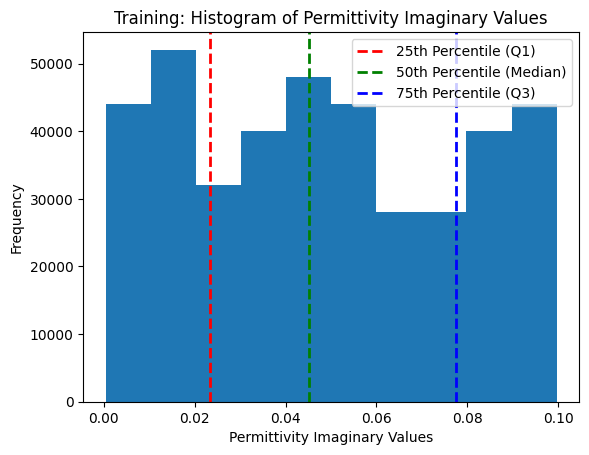

In [20]:
# Showing mean for the permittivity imaginary for training dataframe
q25 = np.percentile(training_dataframe["Permittivity_Imaginary"], 25)
q50 = np.percentile(training_dataframe["Permittivity_Imaginary"], 50)
q75 = np.percentile(training_dataframe["Permittivity_Imaginary"], 75)
plt.hist(training_dataframe["Permittivity_Imaginary"])
plt.xlabel("Permittivity Imaginary Values")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Permittivity Imaginary Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

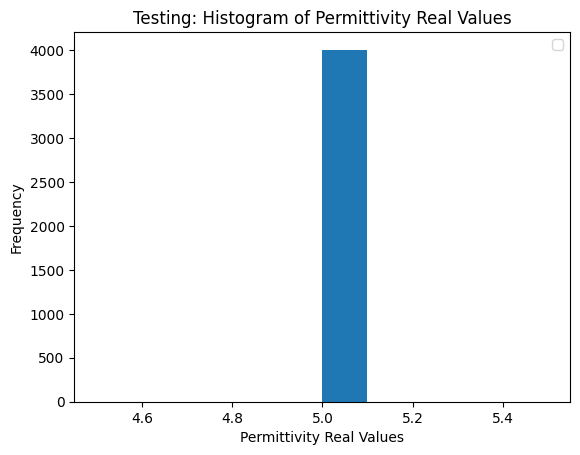

In [21]:
# Showing mean for the permittivity real for testing dataframe
plt.hist(testing_dataframe["Permittivity_Real"])
plt.xlabel("Permittivity Real Values")
plt.ylabel("Frequency")
plt.title("Testing: Histogram of Permittivity Real Values")
plt.legend()
plt.show()

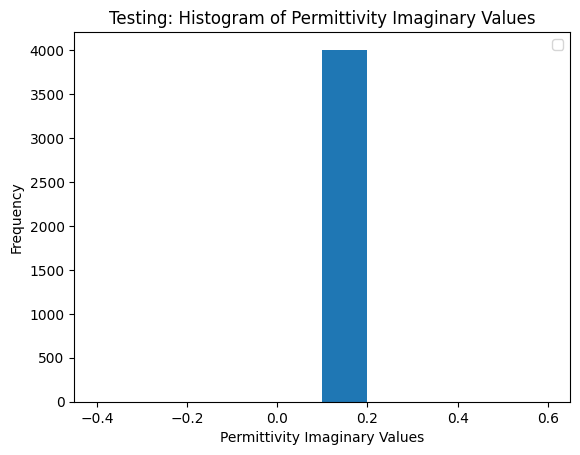

In [22]:
# Showing mean for the permittivity real for training dataframe
plt.hist(testing_dataframe["Permittivity_Imaginary"])
plt.xlabel("Permittivity Imaginary Values")
plt.ylabel("Frequency")
plt.title("Testing: Histogram of Permittivity Imaginary Values")
plt.legend()
plt.show()

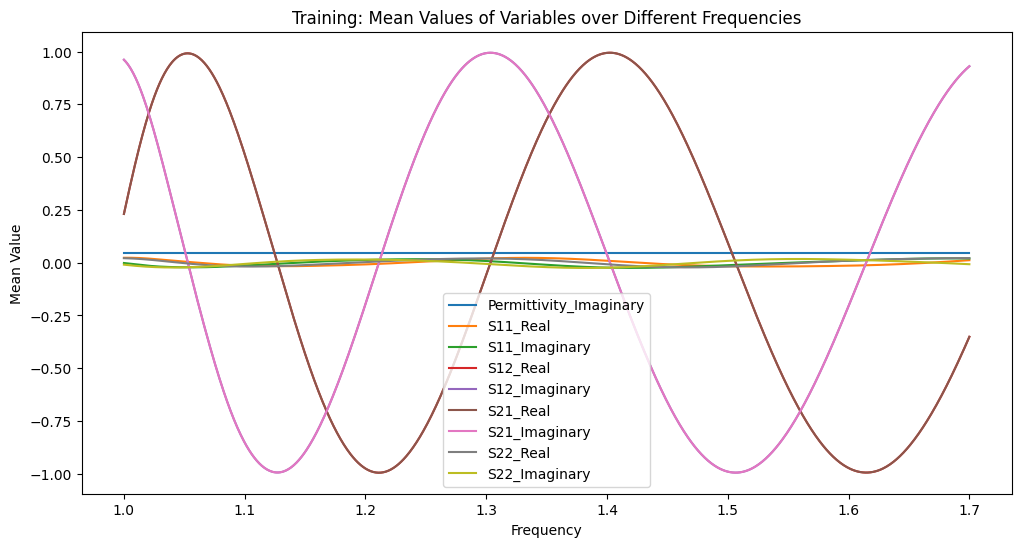

In [23]:
# Plot mean over frequencies for testing dataframe
plt.figure(figsize=(12, 6))
for col in training_mean_predicted_values.columns:
    plt.plot(training_mean_predicted_values.index, training_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Training: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

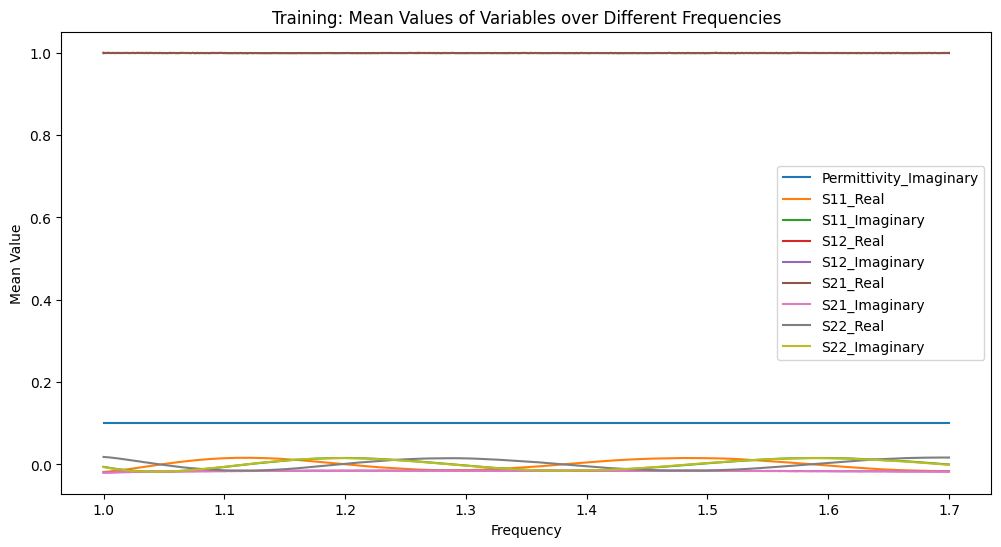

In [24]:
# Plot mean over frequencies for training dataframe
plt.figure(figsize=(12, 6))
for col in testing_mean_predicted_values.columns:
    plt.plot(testing_mean_predicted_values.index, testing_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Training: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

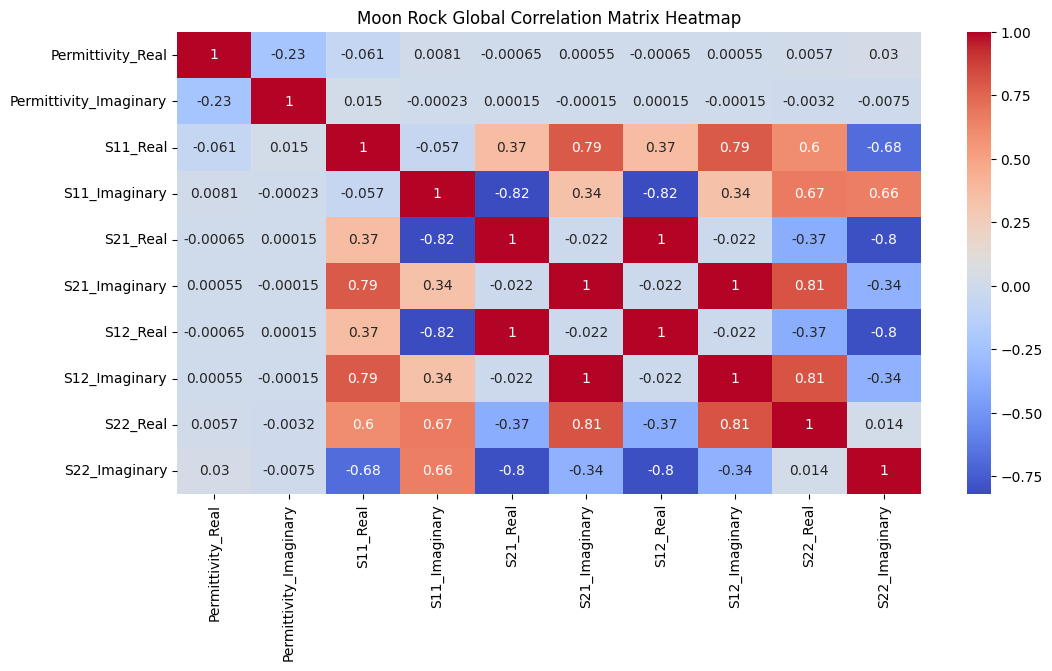

In [25]:
# Heatmap for global
plt.figure(figsize=(12, 6))
sns.heatmap(training_dataframe[['Permittivity_Real', 'Permittivity_Imaginary', 'S11_Real', 'S11_Imaginary', 'S21_Real','S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real','S22_Imaginary']].corr(), annot=True, cmap='coolwarm')
plt.title('Moon Rock Global Correlation Matrix Heatmap')
plt.show()

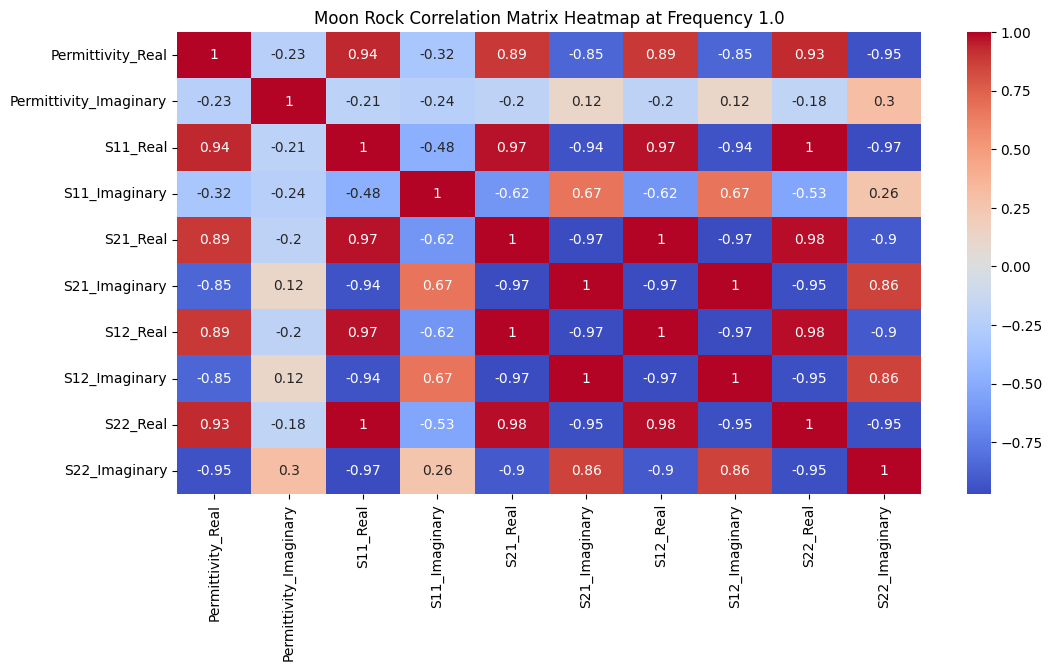

<Figure size 1200x600 with 0 Axes>

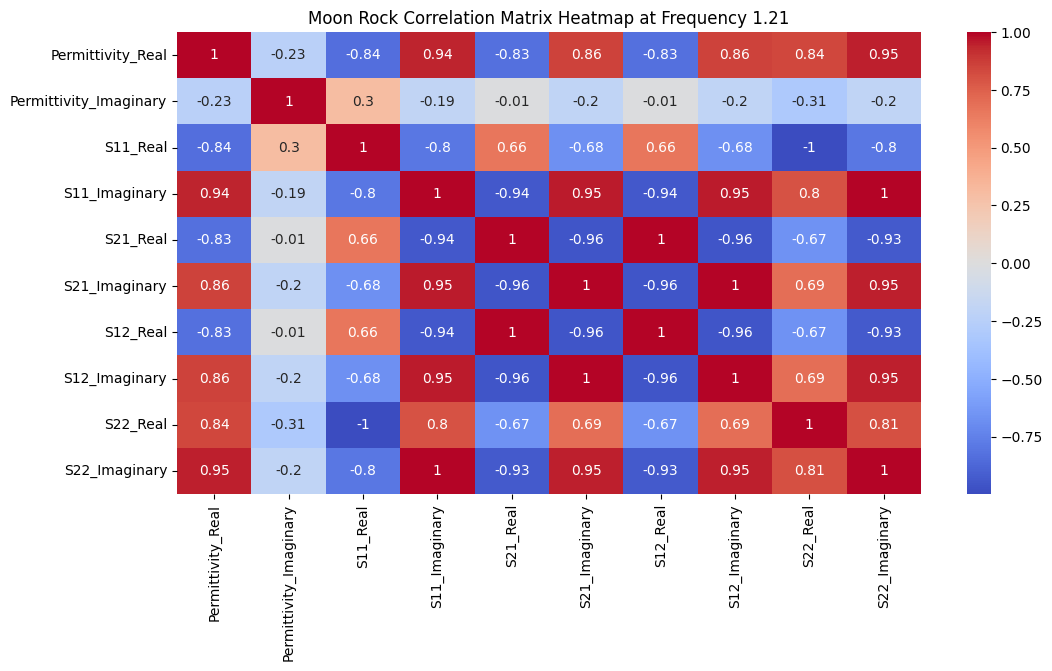

<Figure size 1200x600 with 0 Axes>

In [26]:
# Heatmap for various frequencies
unique_frequencies = np.unique(training_dataframe["Frequency"])
count = 0
for i in range(0, len(unique_frequencies), 300):
    if count < 2:
        plt.figure(figsize=(12, 6))
        sample = training_dataframe[training_dataframe["Frequency"] == unique_frequencies[i]]
        sns.heatmap(sample[['Permittivity_Real', 'Permittivity_Imaginary', 'S11_Real', 'S11_Imaginary', 'S21_Real', 'S21_Imaginary', 'S12_Real', 'S12_Imaginary', 'S22_Real', 'S22_Imaginary']].corr(), annot=True, cmap='coolwarm')
        plt.title(f'Moon Rock Correlation Matrix Heatmap at Frequency {np.round(unique_frequencies[i],3)}')
        plt.figure(figsize=(12, 6))
        count += 1
    else:
        break

# DATA MANIPULATION

In [27]:
# Normalize
training_dataframe["Permittivity_Real"] /= 100
testing_dataframe["Permittivity_Real"] /= 100

In [28]:
# Power transform
no_id = [
 'S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']
bc = QuantileTransformer(random_state=42)
bc.fit(training_dataframe[no_id])
training_dataframe[training_dataframe[no_id].columns] = bc.transform(training_dataframe[no_id])
testing_dataframe[testing_dataframe[no_id].columns]  = bc.transform(testing_dataframe[no_id])

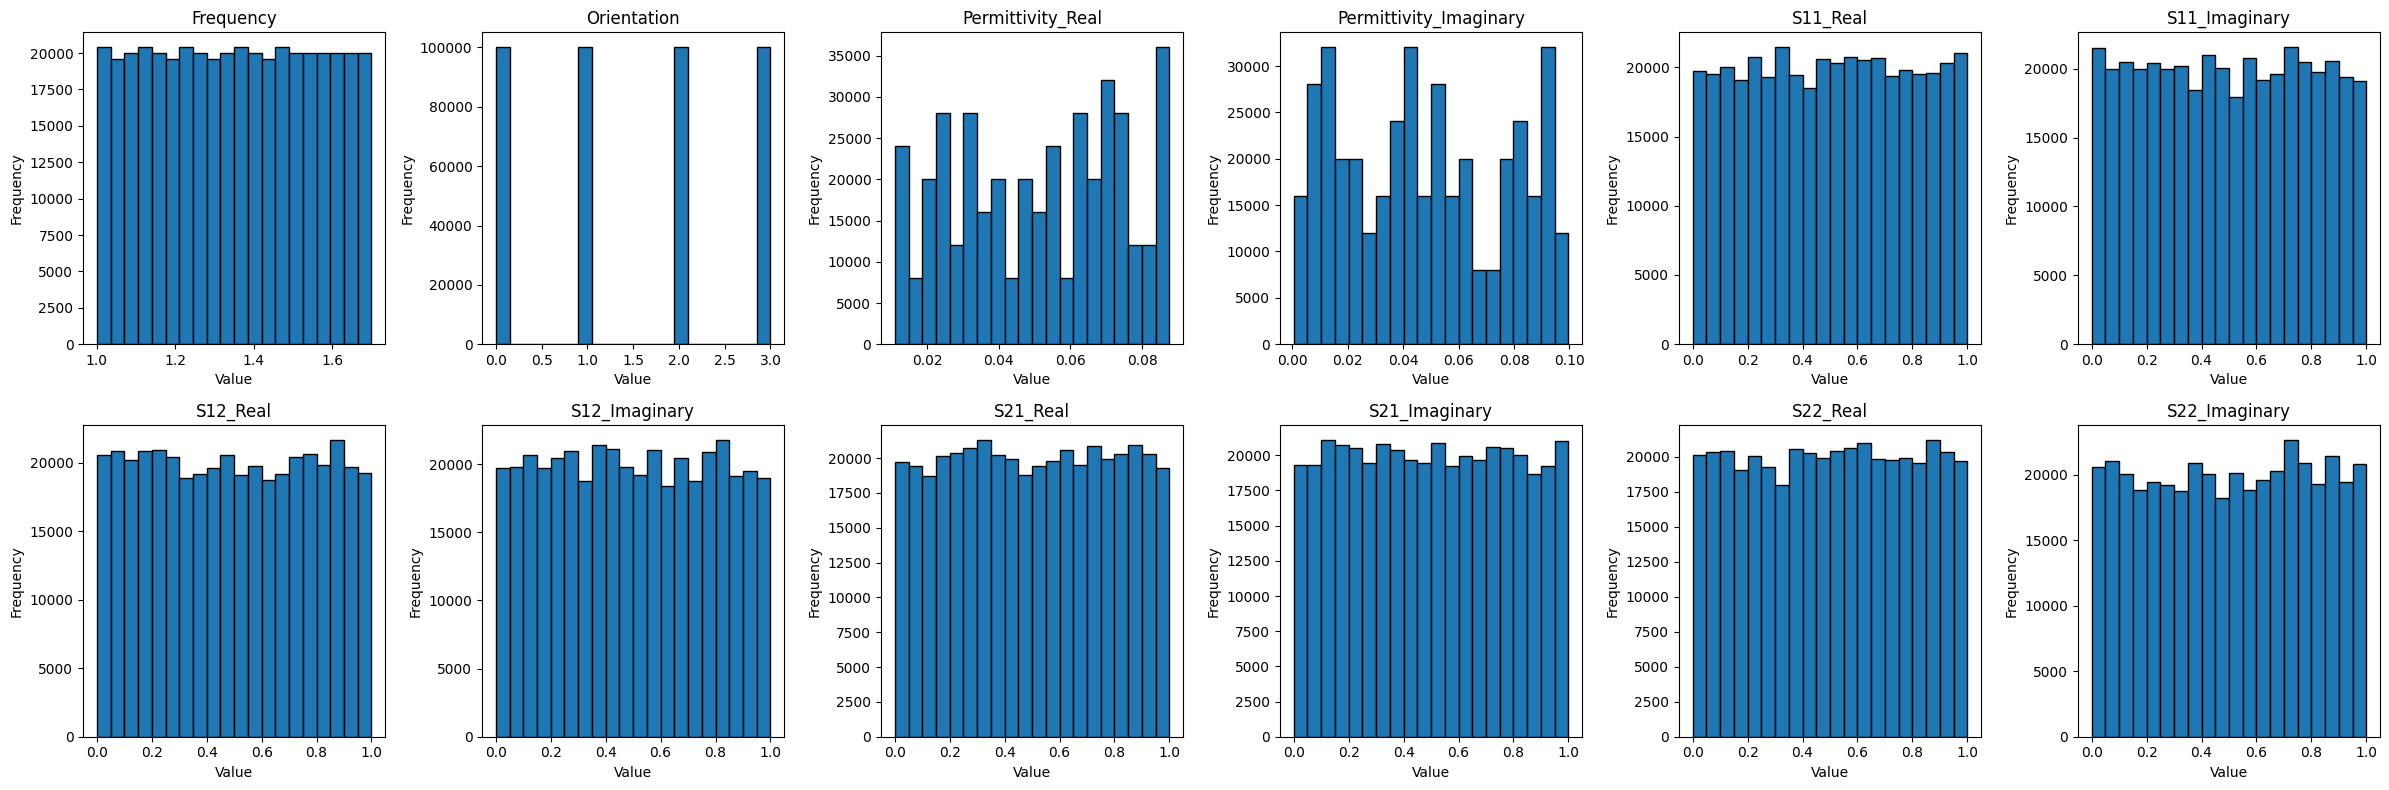

In [29]:
# Plot training histogram
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

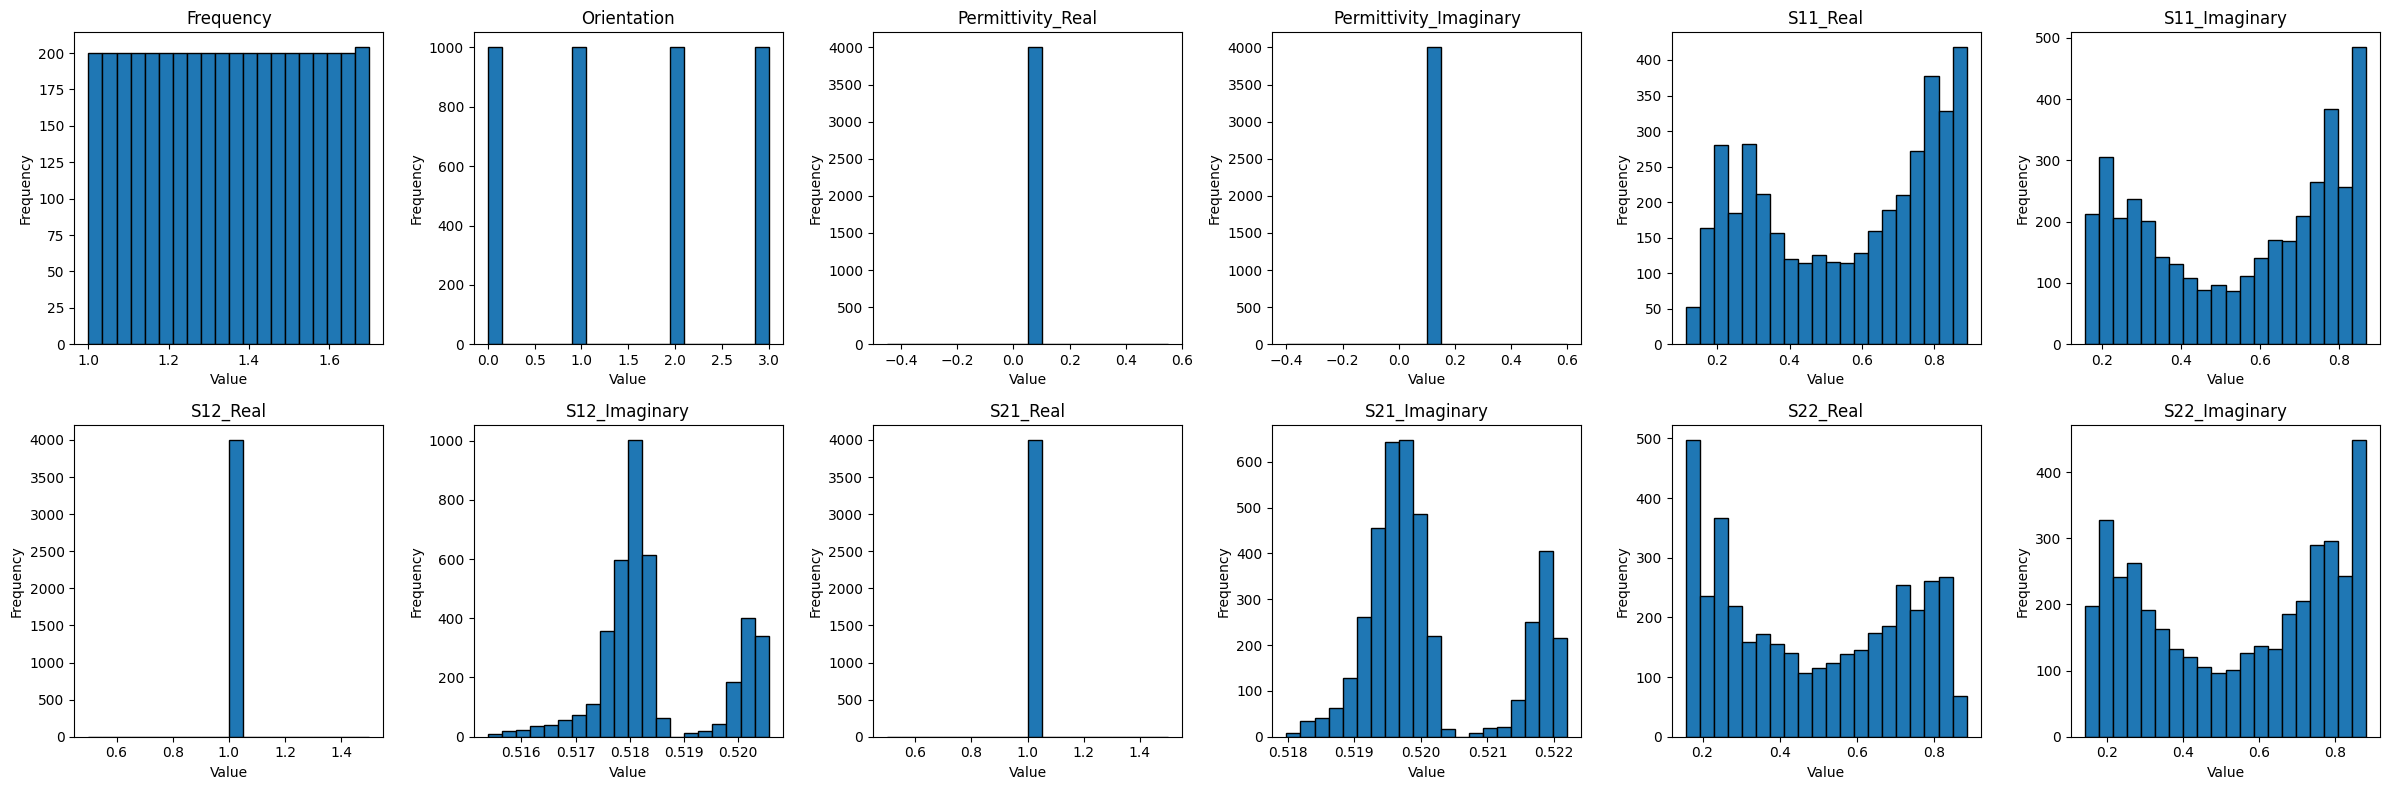

In [30]:
# Plot testing histogram
plt.figure(figsize=(24, 8))
for i, column in enumerate(testing_dataframe.columns):
    plt.subplot(2,6 , i+1)
    plt.hist(testing_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# MODELS

In [31]:
# Hyperparameters
LR = 0.0001
L2 = 0.00001
WD = 0.000001

In [32]:
# Column names
columns = []
for column in training_dataframe.columns:
    if column not in ["Permittivity_Real","Permittivity_Imaginary","ID","Orientation","Frequency"]:
        columns.append(column)
columns

['S11_Real',
 'S11_Imaginary',
 'S12_Real',
 'S12_Imaginary',
 'S21_Real',
 'S21_Imaginary',
 'S22_Real',
 'S22_Imaginary']

In [33]:
# K fold
k_fold_value = 10
X_train = training_dataframe[columns].values
y_train = training_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values
selected_indices = np.arange(len(training_dataframe))
grouped_indices = {}
for idx in selected_indices:
    row = training_dataframe.iloc[idx]
    orientation = row['Orientation']
    frequency = row['Frequency']
    key = (orientation, frequency)
    if key not in grouped_indices:
        grouped_indices[key] = []
    grouped_indices[key].append(idx)

X_train_indices = []
X_test_indices = []
for key, indices in grouped_indices.items():
    train_indices, test_indices = train_test_split(indices, test_size=0.1, random_state=100)
    X_train_indices.extend(train_indices)
    X_test_indices.extend(test_indices)
    grouped_indices[key] = train_indices
X_test_indices.sort()

X_selected = X_train
y_selected = y_train

# grouped_indices = {}
# for idx in selected_indices:
#     row = training_dataframe.iloc[idx]
#     orientation = row['Orientation']
#     frequency = row['Frequency']
#     key = (orientation, frequency)
#     if key not in grouped_indices:
#         grouped_indices[key] = []
#     grouped_indices[key].append(idx)
# kf = KFold(n_splits=5)
X_train_indices_dict = dict()
X_val_indices_dict = dict()
X_test_indices_dict = dict()
for i in range(k_fold_value):
  X_train_indices_dict[i] = []
  X_val_indices_dict[i] = []
  X_test_indices_dict[i] = X_test_indices

# for key, indices in grouped_indices.items():
#     for index, (train_indice_x, val_indice_x) in enumerate(kf.split(indices)):
#       train_indices = train_indice_x
#       val_indices = val_indice_x
#       X_train_indices_dict[index].extend(train_indices)
#       X_val_indices_dict[index].extend(val_indices)

# for i in range(5):
#   X_test_indices_dict[i].sort()

X_train_indices = []
X_val_indices = []
kf = KFold(n_splits=k_fold_value,shuffle=True,random_state=100)
for ind in range(k_fold_value):
  for key, indices in grouped_indices.items():
    train_indices,val_indices = list(kf.split(indices))[ind]
    train_indices = [indices[i] for i in train_indices]
    val_indices = [indices[i] for i in val_indices]
    X_train_indices_dict[ind].extend(train_indices)
    X_val_indices_dict[ind].extend(val_indices)
    # for index, (train_indices, val_indices) in enumerate(kf.split(indices)):
    #   #train_indices, val_indices = train_test_split(indices, test_size=0.1, random_state=100)
    #   X_train_indices.extend(train_indices)
    #   X_val_indices.extend(val_indices)

In [34]:
# Showing number of observations
num_obs_train = len(X_selected[X_train_indices_dict[0]])
num_obs_val = len(X_selected[X_val_indices_dict[0]])
num_obs_test = len(X_train[X_test_indices_dict[0]])
total_obs = num_obs_train + num_obs_val + num_obs_test
data = {'Dataset': ['Training', 'Validation', 'Test', 'Total'],
            'Number of Observations': [num_obs_train, num_obs_val, num_obs_test, total_obs]}
observations_table = pd.DataFrame(data)
print(observations_table)

      Dataset  Number of Observations
0    Training                  324324
1  Validation                   36036
2        Test                   40040
3       Total                  400400


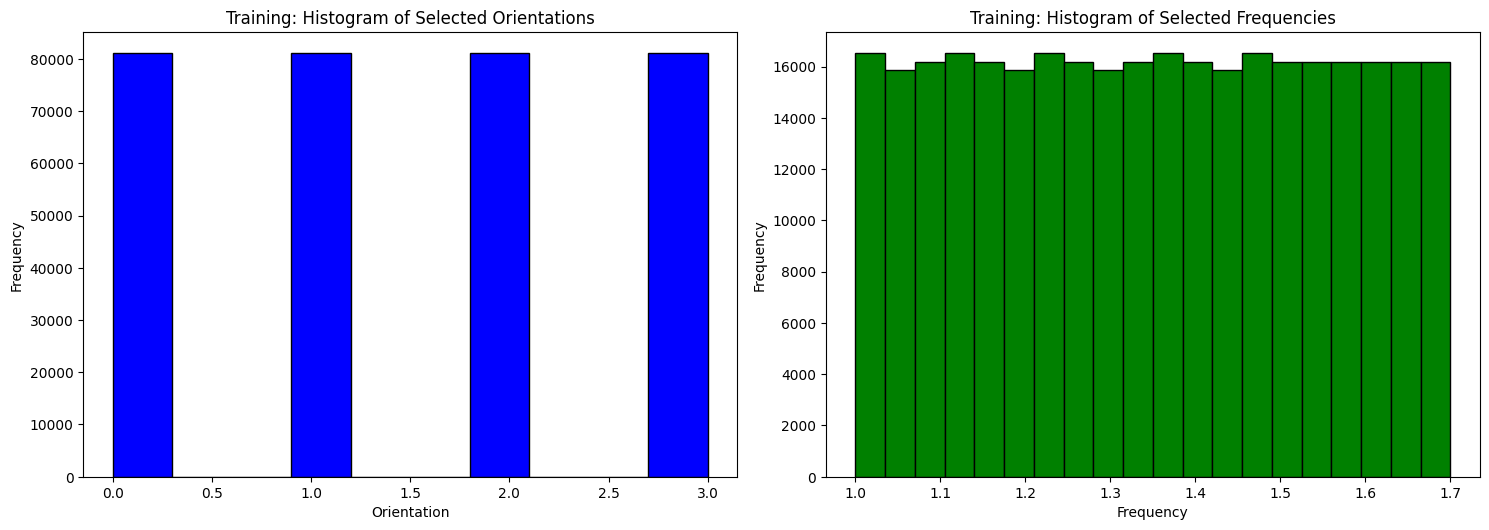

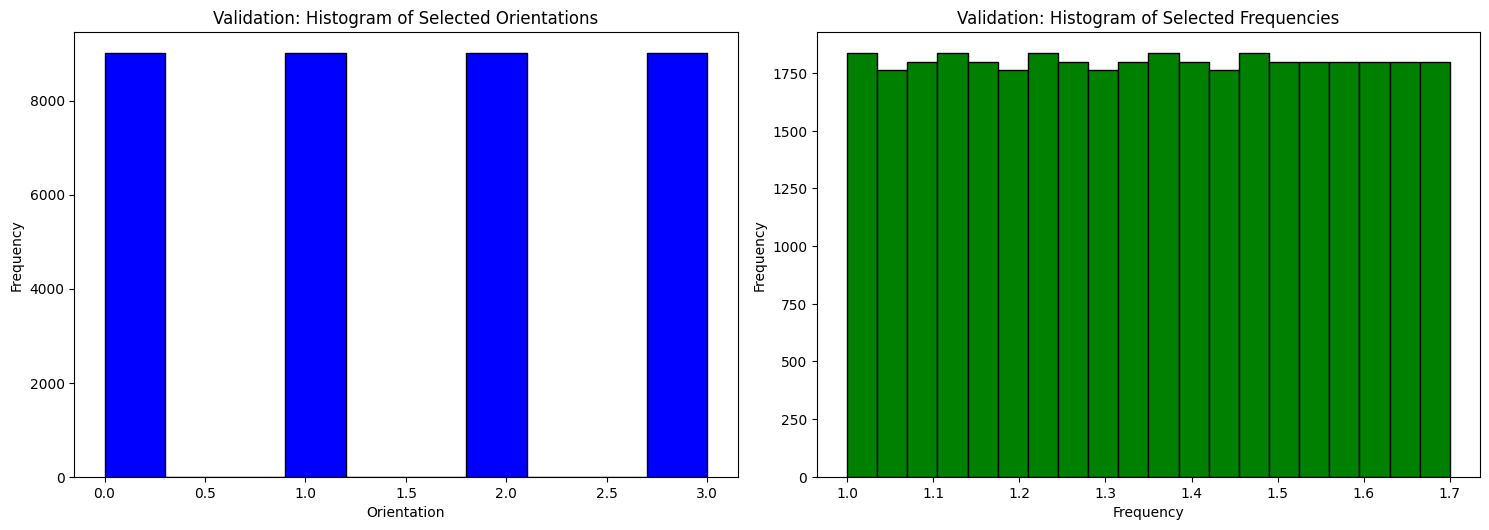

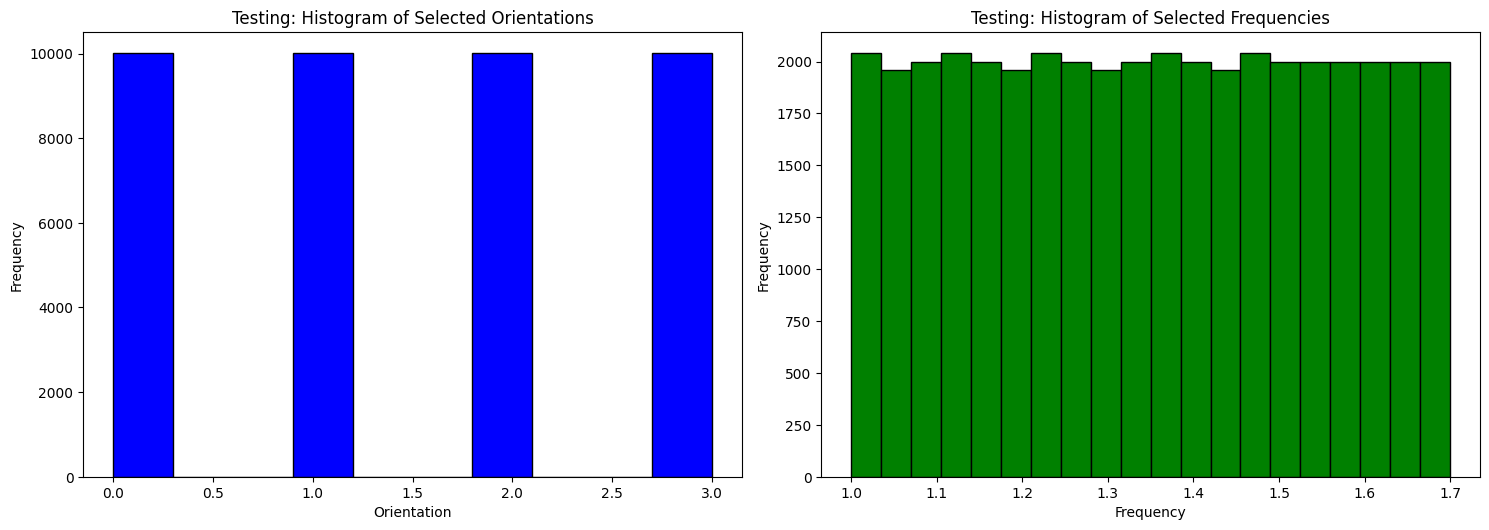

In [35]:
# Showing uniform orientations and frequencies
selected_orientations = training_dataframe.loc[X_train_indices_dict[0], 'Orientation']
selected_frequencies = training_dataframe.loc[X_train_indices_dict[0], 'Frequency']

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(selected_orientations, bins=10, color='blue', edgecolor='black')
plt.title('Training: Histogram of Selected Orientations')
plt.xlabel('Orientation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(selected_frequencies, bins=20, color='green', edgecolor='black')
plt.title('Training: Histogram of Selected Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

selected_orientations = training_dataframe.loc[X_val_indices_dict[0], 'Orientation']
selected_frequencies = training_dataframe.loc[X_val_indices_dict[0], 'Frequency']

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(selected_orientations, bins=10, color='blue', edgecolor='black')
plt.title('Validation: Histogram of Selected Orientations')
plt.xlabel('Orientation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(selected_frequencies, bins=20, color='green', edgecolor='black')
plt.title('Validation: Histogram of Selected Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

selected_orientations = training_dataframe.loc[X_test_indices_dict[0], 'Orientation']
selected_frequencies = training_dataframe.loc[X_test_indices_dict[0], 'Frequency']

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.hist(selected_orientations, bins=10, color='blue', edgecolor='black')
plt.title('Testing: Histogram of Selected Orientations')
plt.xlabel('Orientation')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(selected_frequencies, bins=20, color='green', edgecolor='black')
plt.title('Testing: Histogram of Selected Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [36]:
# Train models
def train_models(X_train,y_train,X_val,y_val):

    def rmse_loss(y_true, y_pred):
      squared_error = tf.square(y_true - y_pred)
      mean_squared_error = tf.reduce_mean(squared_error)
      root_mean_squared_error = tf.sqrt(mean_squared_error)
      return root_mean_squared_error

    nn_model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(16, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
        keras.layers.Dense(y_train.shape[1], activation='linear')
    ])


    nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=L2,weight_decay=WD),
                  loss=[rmse_loss],
                  metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
    nn_model.summary()
    history = nn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25,shuffle=True,batch_size=1001)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('FNN: Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend(['Train', 'Validation'])
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('FNN: Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    plt.tight_layout()
    plt.show()

    xgb_model = xgb.XGBRegressor(n_jobs=-1,device="gpu",n_estimators=100,eval_metric="rmse",verbosity=3,max_depth=5)
    xgb_model.fit(X_train, y_train)

    X_train_tensor = torch.tensor(X_train , dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    tabnet_model = TabNetRegressor(
    device_name="cuda"
    )
    tabnet_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        max_epochs=10,
        batch_size=1001,
        eval_metric=["rmse"]
    )
    return nn_model, xgb_model, tabnet_model
    #    optimizer_params={
   #         "lr": LR,  # Set your desired learning rate here
     #       "weight_decay": WD,  # Set your desired weight decay here
    #    }  # Use RMSE as the evaluation metric

In [ ]:
# Call train models function on each k fold
model_dictionary = dict()
for i in range(index+1):
  X_train_index = X_train_indices_dict[i]
  X_val_index = X_val_indices_dict[i]
  X_test_index = X_test_indices_dict[i]
  X_train = X_selected[X_train_index]
  y_train = y_selected[X_train_index]
  X_val = X_selected[X_val_index]
  y_val = y_selected[X_val_index]
  X_test = X_selected[X_test_index]
  y_test = y_selected[X_test_index]
  X_train = X_train.astype(float)
  y_train = y_train.astype(float)
  X_val = X_val.astype(float)
  y_val = y_val.astype(float)
  X_test = X_test.astype(float)
  y_test = y_test.astype(float)

  nn_model, xgb_model, tabnet_model = train_models(X_train,y_train,X_val,y_val)
  model_dictionary[i] = [nn_model,xgb_model,tabnet_model]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1152      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 2)                 34        
                                                                 
Total params: 12050 (47.07 KB)
Trainable params: 12050 (47.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/25
324/324 [

# EVALUATION SIMULATION TEST DATA

In [ ]:
# Evaluation tables simulated data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
names = ['Permittivity_Real', 'Permittivity_Imaginary']
model_names = ["FNN","XGBoost","TabNet"]
num_models = len(model_dictionary)
num_targets = 2
y_pred_models = [[] for _ in range(num_models)]
y_test_targets = [[] for _ in range(num_targets)]
for i in range(num_models):
    nn_model, xgb_model, tabnet_model = model_dictionary[i]
    y_pred_nn = np.mean(nn_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_nn[:,0] = y_pred_nn[:,0] * 100
    y_pred_xgb = np.mean(xgb_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_xgb[:,0] = y_pred_xgb[:,0] * 100
    y_pred_tab = np.mean(tabnet_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_tab[:,0] = y_pred_tab[:,0] * 100
    y_pred_models[i] = [y_pred_nn, y_pred_xgb, y_pred_tab]
    y_test_targets[0] = np.mean(y_test[:, 0].reshape(-1,1001),axis=1) * 100
    y_test_targets[1] = np.mean(y_test[:, 1].reshape(-1,1001),axis=1)
for t in range(num_targets):
    metrics_data = []
    y_test_target = y_test_targets[t]
    target_data = {
        "Target": names[t]
    }
    for model_type in range(len(y_pred_models[0])):
        mean = np.zeros_like(y_pred_models[0][model_type][:, t])
        squared_diff_sum = np.zeros_like(y_pred_models[0][model_type][:, t])
        for k_fold in range(len(y_pred_models)):
            y_pred_fold = y_pred_models[k_fold][model_type][:, t]
            mean += y_pred_fold
            squared_diff_sum += (y_pred_fold - mean) ** 2
        mean = mean / len(y_pred_models)
        std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
        mse = mean_squared_error(y_test_target, mean)
        mae = mean_absolute_error(y_test_target, mean)
        rmse = np.sqrt(mse)
        r_squared = r2_score(y_test_target, mean)
        target_data[f"Mean ({model_names[model_type]})"] = mean
        target_data[f"SD ({model_names[model_type]})"] = std_deviation
        target_data[f"MSE ({model_names[model_type]})"] = mse
        target_data[f"MAE ({model_names[model_type]})"] = mae
        target_data[f"RMSE ({model_names[model_type]})"] = rmse
        target_data[f"R² ({model_names[model_type]})"] = r_squared

    metrics_data.append(target_data)
    metrics_df = pd.DataFrame(metrics_data)
    display(metrics_df)

In [ ]:
# Evaluation plots simulated data
names = ['Permittivity_Real', 'Permittivity_Imaginary']
model_names = ["FNN","XGBoost","TabNet"]
num_models = len(model_dictionary)
num_targets = 2
y_pred_models = [[] for _ in range(num_models)]
y_test_targets = [[] for _ in range(num_targets)]
for i in range(num_models):
    nn_model, xgb_model, tabnet_model = model_dictionary[i]
    y_pred_nn = np.mean(nn_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_nn[:,0] = y_pred_nn[:,0] * 100
    y_pred_xgb = np.mean(xgb_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_xgb[:,0] = y_pred_xgb[:,0] * 100
    y_pred_tab = np.mean(tabnet_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_tab[:,0] = y_pred_tab[:,0] * 100
    y_pred_models[i] = [y_pred_nn, y_pred_xgb, y_pred_tab]
    y_test_targets[0] = np.mean(y_test[:, 0].reshape(-1,1001),axis=1) * 100
    y_test_targets[1] = np.mean(y_test[:, 1].reshape(-1,1001),axis=1)
for t in range(num_targets):
  y_test_target = y_test_targets[t]
  plt.figure(figsize=(6, 4))
  plt.plot(range(len(y_test_target)), y_test_target, label='Actual', color='blue', alpha=0.7)
  for model_type in range(len(y_pred_models[0])):
    mean = np.zeros_like(y_pred_models[0][model_type][:, t])
    squared_diff_sum = np.zeros_like(y_pred_models[0][model_type][:, t])
    for k_fold in range(len(y_pred_models)):
      y_pred_fold = y_pred_models[k_fold][model_type][:, t]
      mean += y_pred_fold
    mean = mean / len(y_pred_models)
    for k_fold in range(len(y_pred_models)):
      y_pred_fold = y_pred_models[k_fold][model_type][:, t]
      squared_diff_sum += (y_pred_fold - mean) ** 2
    std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
    std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
    plt.plot(range(len(y_test_target)), mean, label=f'Predicted Mean (Model {model_names[model_type]})', alpha=0.7)
    plt.fill_between(range(len(y_test_target)), mean - std_deviation, mean + std_deviation, alpha=0.2, label=f'Standard Deviation (Model {model_names[model_type]})')
  plt.title(f'Simulated Moon Rock Actual and Predicted (Target {names[t]})')
  plt.xlabel('Data Point')
  plt.ylabel('Value')
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.show()

# EVALUATION ACTUAL TEST DATA

In [ ]:
X_test = testing_dataframe[columns].values
y_test = testing_dataframe[['Permittivity_Real', 'Permittivity_Imaginary']].values

In [ ]:
# Evaluation tables actual data
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
names = ['Permittivity_Real', 'Permittivity_Imaginary']
model_names = ["FNN","XGBoost","TabNet"]
num_models = len(model_dictionary)
num_targets = 2
y_pred_models = [[] for _ in range(num_models)]
y_test_targets = [[] for _ in range(num_targets)]
for i in range(num_models):
    nn_model, xgb_model, tabnet_model = model_dictionary[i]
    y_pred_nn = np.mean(nn_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_nn[:,0] = y_pred_nn[:,0] * 100
    y_pred_xgb = np.mean(xgb_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_xgb[:,0] = y_pred_xgb[:,0] * 100
    y_pred_tab = np.mean(tabnet_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_tab[:,0] = y_pred_tab[:,0] * 100
    y_pred_models[i] = [y_pred_nn, y_pred_xgb, y_pred_tab]
    y_test_targets[0] = np.mean(y_test[:, 0].reshape(-1,1001),axis=1) * 100
    y_test_targets[1] = np.mean(y_test[:, 1].reshape(-1,1001),axis=1)
for t in range(num_targets):
    metrics_data = []
    y_test_target = y_test_targets[t]
    target_data = {
        "Target": names[t]
    }
    for model_type in range(len(y_pred_models[0])):
        mean = np.zeros_like(y_pred_models[0][model_type][:, t])
        squared_diff_sum = np.zeros_like(y_pred_models[0][model_type][:, t])
        for k_fold in range(len(y_pred_models)):
            y_pred_fold = y_pred_models[k_fold][model_type][:, t]
            mean += y_pred_fold
            squared_diff_sum += (y_pred_fold - mean) ** 2
        mean = mean / len(y_pred_models)
        std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
        mse = mean_squared_error(y_test_target, mean)
        mae = mean_absolute_error(y_test_target, mean)
        rmse = np.sqrt(mse)
        r_squared = r2_score(y_test_target, mean)
        target_data[f"Mean ({model_names[model_type]})"] = mean
        target_data[f"SD ({model_names[model_type]})"] = std_deviation
        target_data[f"MSE ({model_names[model_type]})"] = mse
        target_data[f"MAE ({model_names[model_type]})"] = mae
        target_data[f"RMSE ({model_names[model_type]})"] = rmse
        target_data[f"R² ({model_names[model_type]})"] = r_squared

    metrics_data.append(target_data)
    metrics_df = pd.DataFrame(metrics_data)
    display(metrics_df)

In [ ]:
# Evaluation plots actual data
names = ['Permittivity_Real', 'Permittivity_Imaginary']
model_names = ["FNN","XGBoost","TabNet"]
num_models = len(model_dictionary)
num_targets = 2
y_pred_models = [[] for _ in range(num_models)]
y_test_targets = [[] for _ in range(num_targets)]
for i in range(num_models):
    nn_model, xgb_model, tabnet_model = model_dictionary[i]
    y_pred_nn = np.mean(nn_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_nn[:,0] = y_pred_nn[:,0] * 100
    y_pred_xgb = np.mean(xgb_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_xgb[:,0] = y_pred_xgb[:,0] * 100
    y_pred_tab = np.mean(tabnet_model.predict(X_test).reshape(-1,1001,2),axis=1)
    y_pred_tab[:,0] = y_pred_tab[:,0] * 100
    y_pred_models[i] = [y_pred_nn, y_pred_xgb, y_pred_tab]
    y_test_targets[0] = np.mean(y_test[:, 0].reshape(-1,1001),axis=1) * 100
    y_test_targets[1] = np.mean(y_test[:, 1].reshape(-1,1001),axis=1)
for t in range(num_targets):
  y_test_target = y_test_targets[t]
  plt.figure(figsize=(6, 4))
  plt.plot(range(len(y_test_target)), y_test_target, label='Actual', color='blue', alpha=0.7)
  for model_type in range(len(y_pred_models[0])):
    mean = np.zeros_like(y_pred_models[0][model_type][:, t])
    squared_diff_sum = np.zeros_like(y_pred_models[0][model_type][:, t])
    for k_fold in range(len(y_pred_models)):
      y_pred_fold = y_pred_models[k_fold][model_type][:, t]
      mean += y_pred_fold
    mean = mean / len(y_pred_models)
    for k_fold in range(len(y_pred_models)):
      y_pred_fold = y_pred_models[k_fold][model_type][:, t]
      squared_diff_sum += (y_pred_fold - mean) ** 2
    std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
    std_deviation = np.sqrt(squared_diff_sum / len(y_pred_models))
    plt.plot(range(len(y_test_target)), mean, label=f'Predicted Mean (Model {model_names[model_type]})', alpha=0.7)
    plt.fill_between(range(len(y_test_target)), mean - std_deviation, mean + std_deviation, alpha=0.2, label=f'Standard Deviation (Model {model_names[model_type]})')
  plt.title(f'Actual Moon Rock Actual and Predicted (Target {names[t]})')
  plt.xlabel('Data Point')
  plt.ylabel('Value')
  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.show()